# Don’t be Afraid of Nonparametric Topic Models (Part 2: Python)

### Dive into an easy step-by-step tutorial on how to implement/evaluate a Hierarchical Dirichlet Process model

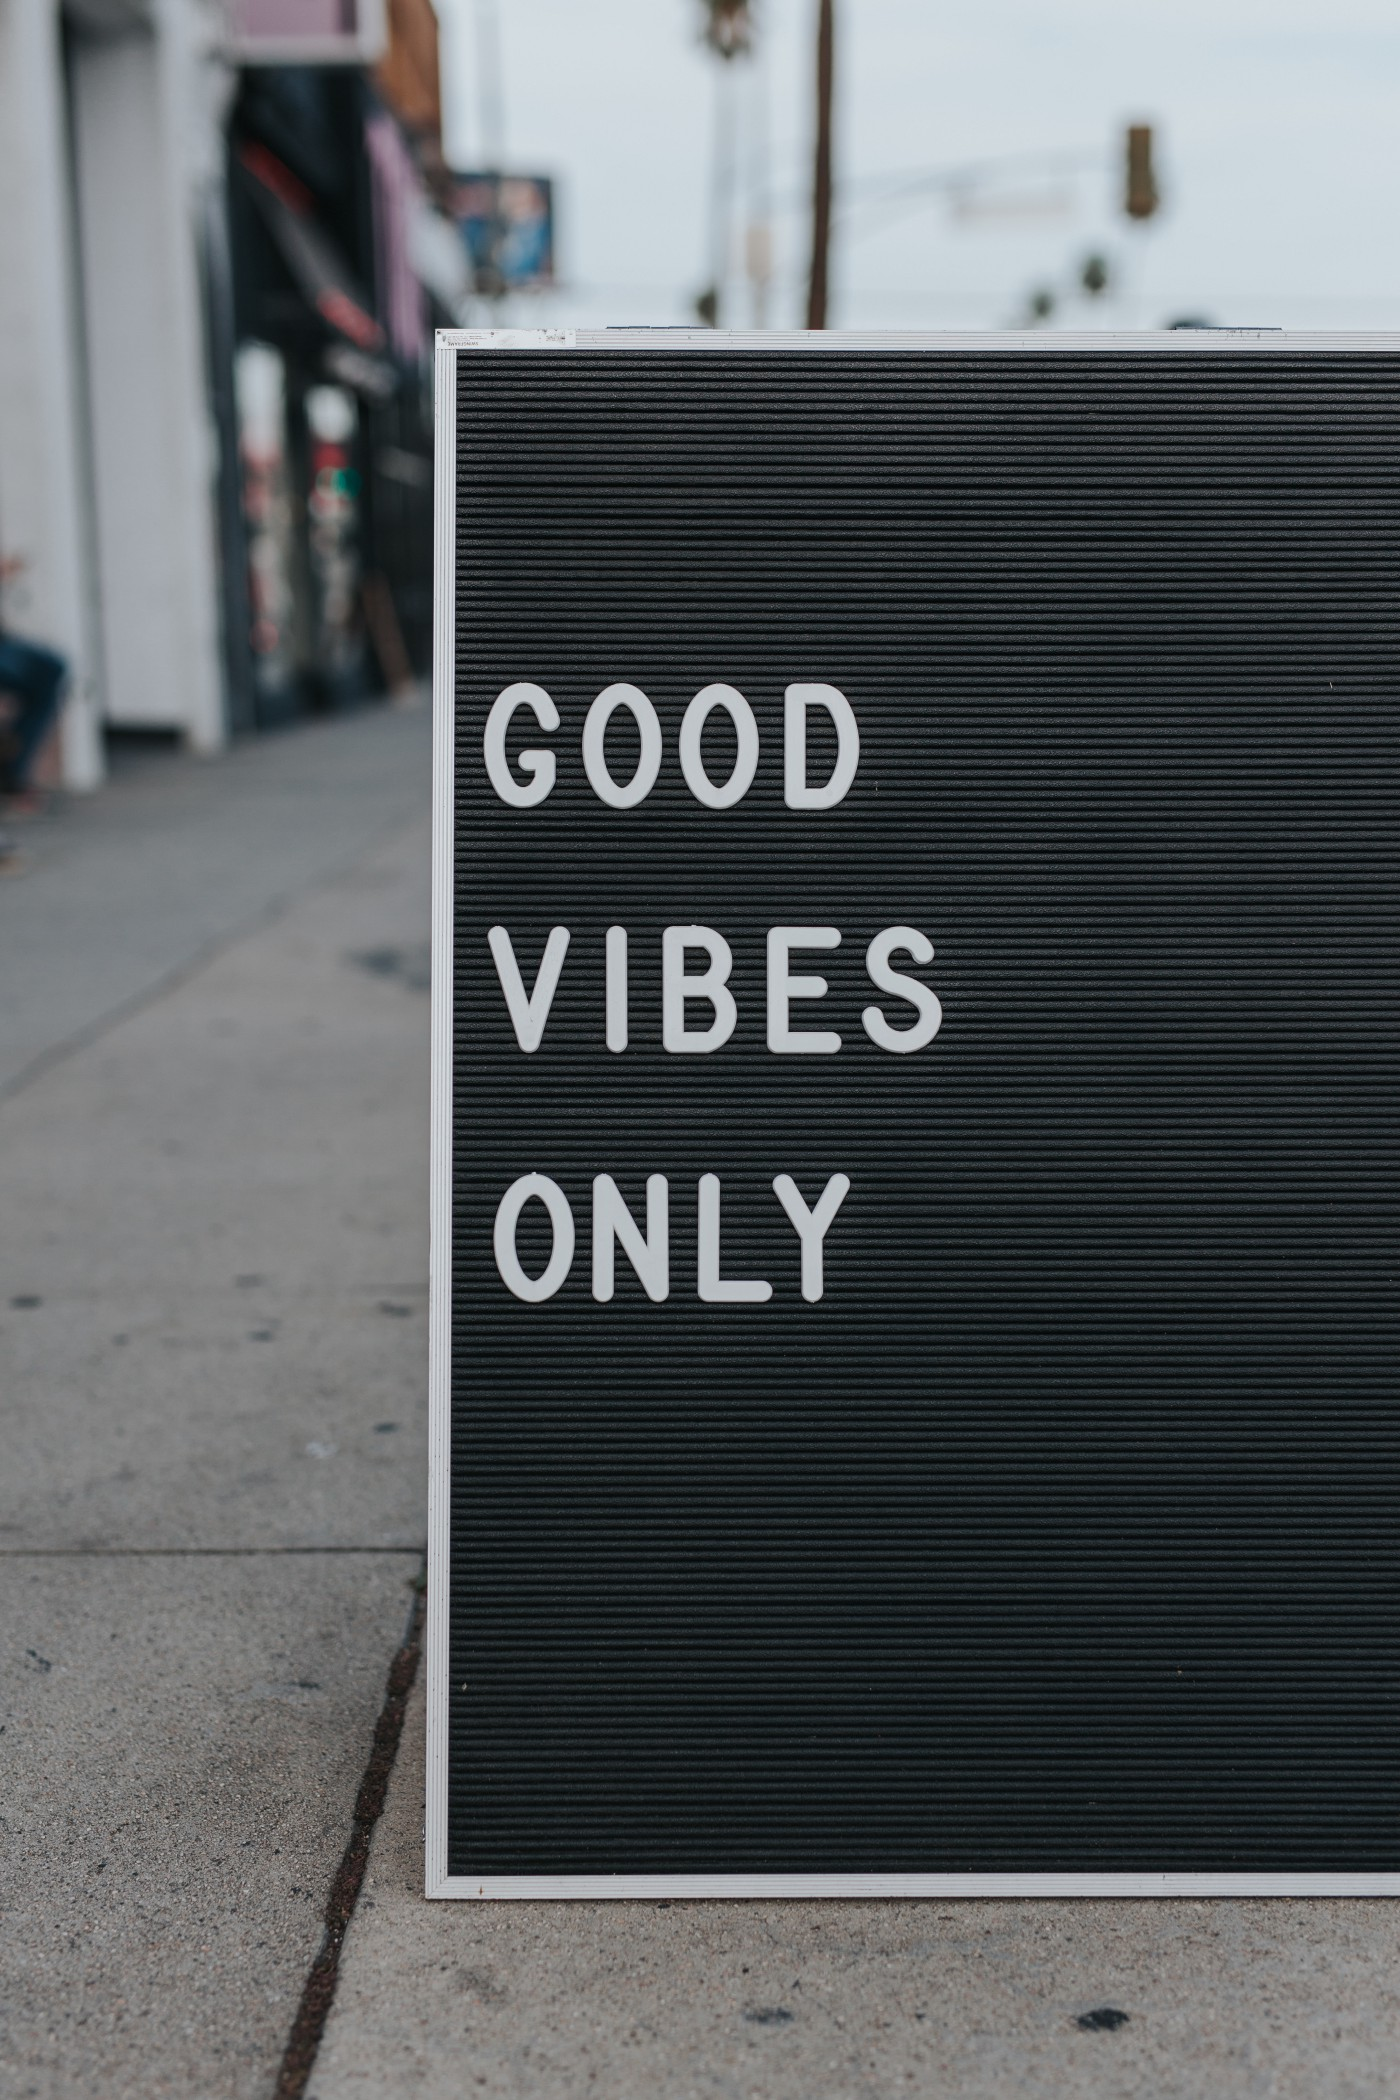

## Load packages

In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import string
import re
import sys

# Sklearn
"""
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Link to import: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups
"""
from sklearn.datasets import fetch_20newsgroups

# Plotting
import matplotlib.pyplot as plt



### Prep stopwords

In [2]:
import nltk
nltk.download('stopwords', quiet=True) # downloads and installs the stop words package from Natural Language Toolkit

from nltk.corpus import stopwords # imports a list of stopwords from the corpus package
st_words = stopwords.words('english') # assigns an array of english stopwords to variable
st_words.extend(['from', 'subject', 're', 'edu', 'use']) # appends additional stopwords to the list of stopwords

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


### Read 20Newsgroup data

In [3]:
news = fetch_20newsgroups(subset='train') # import fron skleanr

In [4]:
# Build master df
"""
Constructs a pandas DataFrame where:
The first column contains the target labels (integers representing the newsgroups).
The second column contains the actual text of the newsgroup posts.

.T transposes the DataFrame. This means that the rows and columns are swapped, turning the list of [news.target, news.data] into a DataFrame with two columns: one for news.target (category labels) and one for news.data (text).
After transposition, the DataFrame will have one row for each document, and two columns:
Column 0: Target category (as integers).
Column 1: The document text (raw text data).

"""
news_df = pd.DataFrame([news.target, news.data]).T
"""news_df = news_df.set_index(0)
news_df.reset_index(inplace=True)"""
news_df = pd.concat([news_df, pd.Series(news.target_names)],axis=1, join="inner") # Attempts to concatenate the DataFrame with a new column containing newsgroup names.

news_df.columns = ["topic_id", "content", "topic_name"] # renames the DataFrame columns to reflect the topic_id, content, and the newly added topic_name.
news_df.head() # news_df.head() returns the first 5 rows of the news_df DataFrame

topic_id                                            content  \
0        7  From: lerxst@wam.umd.edu (where's my thing)\nS...   
1        4  From: guykuo@carson.u.washington.edu (Guy Kuo)...   
2        4  From: twillis@ec.ecn.purdue.edu (Thomas E Will...   
3        1  From: jgreen@amber (Joe Green)\nSubject: Re: W...   
4       14  From: jcm@head-cfa.harvard.edu (Jonathan McDow...   

                 topic_name  
0               alt.atheism  
1             comp.graphics  
2   comp.os.ms-windows.misc  
3  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware

In [5]:
"""
This line extracts all the text data from the content column of the news_df DataFrame and stores it as a Python list called doc_list. Each element of the list is a document from the newsgroup dataset.
"""
doc_list = news_df.content.values.tolist()

In [6]:
doc_list[0] # prints the first text data in the content column

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### Removing @s, new lines and single quotes

In [7]:
# Remove Emails
doc_list = [re.sub(r'\S*@\S*\s?', '', sent) for sent in doc_list]

# Remove new line characters
doc_list = [re.sub(r'\s+', ' ', sent) for sent in doc_list]

# Remove distracting single quotes
doc_list = [re.sub(r"\'", "", sent) for sent in doc_list]


In [8]:
doc_list[3]

'From: (Joe Green) Subject: Re: Weitek P9000 ? Organization: Harris Computer Systems Division Lines: 14 Distribution: world NNTP-Posting-Host: amber.ssd.csd.harris.com X-Newsreader: TIN [version 1.1 PL9] Robert J.C. Kyanko wrote: > writes in article > > Anyone know about the Weitek P9000 graphics chip? > As far as the low-level stuff goes, it looks pretty nice. Its got this > quadrilateral fill command that requires just the four points. Do you have Weiteks address/phone number? Id like to get some information about this chip. -- Joe Green Harris Corporation Computer Systems Division "The only thing that really scares me is a person with no sense of humor." -- Jonathan Winters '

### Removing punctuations, lowercasing and splitting text into lists

In [9]:
# Gensim
import gensim
"""
# removes converts each word in doc_list into lowercase, removes all accents from all words in each document,
and removes words that are shorter than 3 letters
"""
word_list = [gensim.utils.simple_preprocess(txt, deacc=True, min_len=3) for txt in doc_list]

In [10]:
word_list[2][:10]

['from',
 'thomas',
 'willis',
 'subject',
 'questions',
 'organization',
 'purdue',
 'university',
 'engineering',
 'computer']

### Bigram model to capture co-occurent words

In [11]:

from gensim.models import Phrases
from gensim.models.phrases import Phraser

"""
"min_count" Ignores all words and bigrams that occur less than 5 times.

"threshold" Controls the sensitivity of bigram detection.
A higher threshold makes it harder for word pairs to be considered
as a bigram (it’s a scoring parameter based on how likely the words are to co-occur).

"""
bigram = Phrases(word_list, min_count=5, threshold=100)

bigram_model = Phraser(bigram)


### Remove standard and extended Stopwords

In [12]:
# Example of stop word removal process
sentence = "A letter has been written asking him to be released"
for word in sentence.split():
    if word not in st_words:
        print("Kept ==> " +word)
    else:
        print("Removed: " +word)

Kept ==> A
Kept ==> letter
Removed: has
Removed: been
Kept ==> written
Kept ==> asking
Removed: him
Removed: to
Removed: be
Kept ==> released


In [13]:
"""
This line removes stopwords from the tokenized documents.
The result, word_list_nostops, is a list of documents (each represented as a list of words) with stopwords filtered out.

Note: This line uses list comprehension and creates a new list called "word_list_nostops". This loop
goes through each document (txt) in word_list, and then it goes over each word (word) in the document (txt).
If any of the words in the document are stop words they are ignored. If any of the words in the document are NOT stop words they are appended to the
list word_list_nostops.

link to list comprehension: https://www.w3schools.com/python/python_lists_comprehension.asp

"""
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]

In [14]:
word_list_nostops[2][:6]

['thomas', 'willis', 'questions', 'organization', 'purdue', 'university']

### Create Bigrams

In [15]:
"""
When you apply bigram_model to w_vec, it looks for pairs of words (bigrams) that frequently appear together according to the bigram model created earlier.
"""
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]

In [16]:
word_bigrams[2][:7]

['thomas',
 'willis',
 'questions',
 'organization',
 'purdue',
 'university',
 'engineering']

### Word Lemmatization

In [17]:
import spacy

## Example showing lemmatization
sentence = "A letter has been written asking him to be released"

spC = spacy.load('en_core_web_sm')

lemma_sentence = spC(sentence)
for token in lemma_sentence:
    print(token.text + " ==> " +token.lemma_ + ", " + token.pos_) #POS = Part Of Speech

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


A ==> a, DET
letter ==> letter, NOUN
has ==> have, AUX
been ==> be, AUX
written ==> write, VERB
asking ==> ask, VERB
him ==> he, PRON
to ==> to, PART
be ==> be, AUX
released ==> release, VERB


In [18]:

spC = spacy.load('en_core_web_sm')
postags = ['NOUN','VERB', 'ADV', 'ADJ'] # Keep nouns, adj, verbs, and adverbs


def lemmatize(word_list, ptags = postags ):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists


In [19]:
# Lemmatize bigrams
word_list_lemmatized = lemmatize(word_bigrams)


In [20]:
word_list_lemmatized[2][:7]

['question',
 'organization',
 'purdue',
 'university',
 'engineering',
 'computer',
 'network']

#### (Alternative, tried using stemming with no improvement)

In [21]:
from gensim.parsing.porter import PorterStemmer
p = PorterStemmer()
def stemming(word_list):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        lem_lists.append([p.stem(token) for token in vec])
    
    return lem_lists

word_list_stem = stemming(word_bigrams)

## HDP Model

<img src="imgs/HDP.png" style="width:70%; height:90%;">

In [22]:
import tomotopy as tp

hdp = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=5, rm_top=7,
                 gamma=1, alpha=0.5, initial_k=10, seed=99999)

# Add docs to train
for vec in word_list_lemmatized:
    hdp.add_doc(vec)

# Initiate MCMC burn-in 
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)
print('Training...', file=sys.stderr, flush=True)


/var/folders/p4/gk0s61d14tq4_l0l3m84p6jc0000gn/T/ipykernel_51646/2158912361.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...


Num docs: 20 , Vocab size: 127 , Num words: 922
Removed top words: ['year', 'line', 'car', 'scsi', 'option', 'article', 'get']


In [23]:
# Train model
mcmc_iter=1000
for i in range(0, mcmc_iter, 100):
    hdp.train(100, workers=3)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))


Iteration: 0	Log-likelihood: -4.0862632620080435	Num. of topics: 18
Iteration: 100	Log-likelihood: -4.096975459368053	Num. of topics: 17
Iteration: 200	Log-likelihood: -4.081429905370072	Num. of topics: 16
Iteration: 300	Log-likelihood: -4.082339647728794	Num. of topics: 14
Iteration: 400	Log-likelihood: -4.085881420760633	Num. of topics: 14
Iteration: 500	Log-likelihood: -4.097852971294744	Num. of topics: 14
Iteration: 600	Log-likelihood: -4.065106492134689	Num. of topics: 14
Iteration: 700	Log-likelihood: -4.07709419848758	Num. of topics: 15
Iteration: 800	Log-likelihood: -4.07287863726035	Num. of topics: 14
Iteration: 900	Log-likelihood: -4.088232783858166	Num. of topics: 14


/var/folders/p4/gk0s61d14tq4_l0l3m84p6jc0000gn/T/ipykernel_51646/1376892705.py:4: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100, workers=3)


#### Get topics

In [24]:
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [25]:
hdp_topics = get_hdp_topics(hdp)

In [26]:
hdp_topics[0]

[('module', 0.09478312730789185),
 ('ssf', 0.09478312730789185),
 ('flight', 0.08530797809362411),
 ('power', 0.08014251291751862),
 ('capability', 0.07583282887935638),
 ('shuttle', 0.06635767966508865),
 ('station', 0.06635767966508865),
 ('redesign', 0.06635767966508865),
 ('orbiter', 0.05688253045082092),
 ('space', 0.05688253045082092)]

#### Evaluate coherence

In [27]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Build gensim objects
vocab = corpora.Dictionary(word_list_lemmatized)
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Build topic list from dictionary
topic_list=[]
for k, tups in hdp_topics.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)



In [28]:
topic_list[3]

['rate',
 'company',
 'pay',
 'ticket',
 'state',
 'buy',
 'performance',
 'drive',
 'fast',
 'good']

In [29]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list_lemmatized, 
                    coherence='c_v')
    
cm.get_coherence()

0.44855686190396665

#### Inference

In [30]:
test_doc = word_list_lemmatized[0]

doc_inst = hdp.make_doc(test_doc)

topic_dist, ll = hdp.infer(doc_inst)

topic_idx = np.array(topic_dist).argmax()
topic_idx

10

In [31]:
hdp.get_topic_words(topic_idx)

[('use', 0.02522296831011772),
 ('well', 0.02430485561490059),
 ('think', 0.02430485561490059),
 ('take', 0.023629648610949516),
 ('system', 0.022898223251104355),
 ('question', 0.022898223251104355),
 ('much', 0.022096989676356316),
 ('know', 0.02186235599219799),
 ('call', 0.020892156288027763),
 ('come', 0.020678235217928886)]

In [32]:
news_df.head(10)

topic_id                                            content  \
0        7  From: lerxst@wam.umd.edu (where's my thing)\nS...   
1        4  From: guykuo@carson.u.washington.edu (Guy Kuo)...   
2        4  From: twillis@ec.ecn.purdue.edu (Thomas E Will...   
3        1  From: jgreen@amber (Joe Green)\nSubject: Re: W...   
4       14  From: jcm@head-cfa.harvard.edu (Jonathan McDow...   
5       16  From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...   
6       13  From: bmdelane@quads.uchicago.edu (brian manni...   
7        3  From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...   
8        2  From: holmes7000@iscsvax.uni.edu\nSubject: WIn...   
9        4  From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...   

                 topic_name  
0               alt.atheism  
1             comp.graphics  
2   comp.os.ms-windows.misc  
3  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware  
5            comp.windows.x  
6              misc.forsale  
7                 rec.autos  
8           rec.motorcycles  
9        rec.sport.baseball

#### Word Clouds

In [33]:
from scripts.wordcloud_funcs import hdp_topics_to_wordclouds

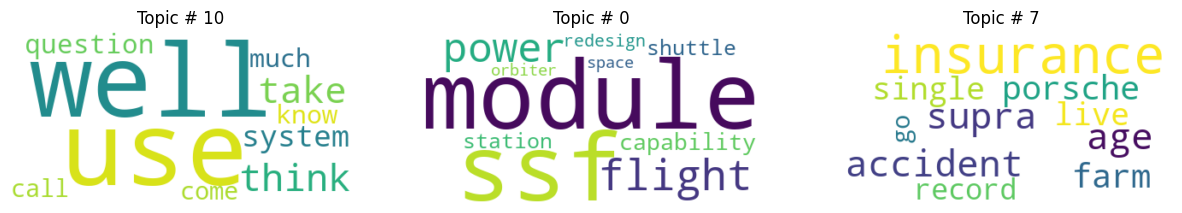

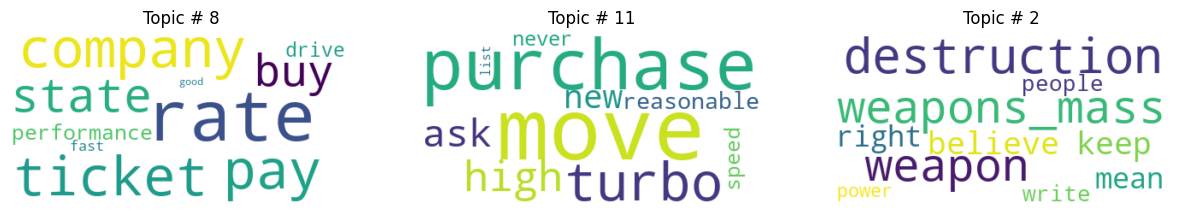

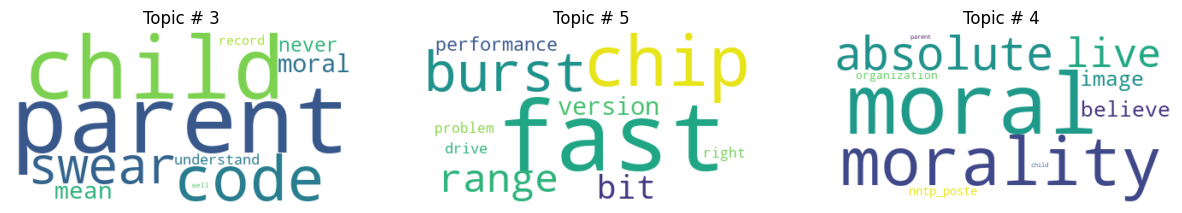

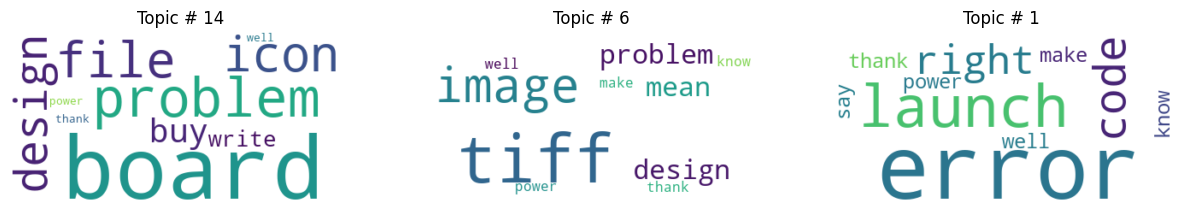

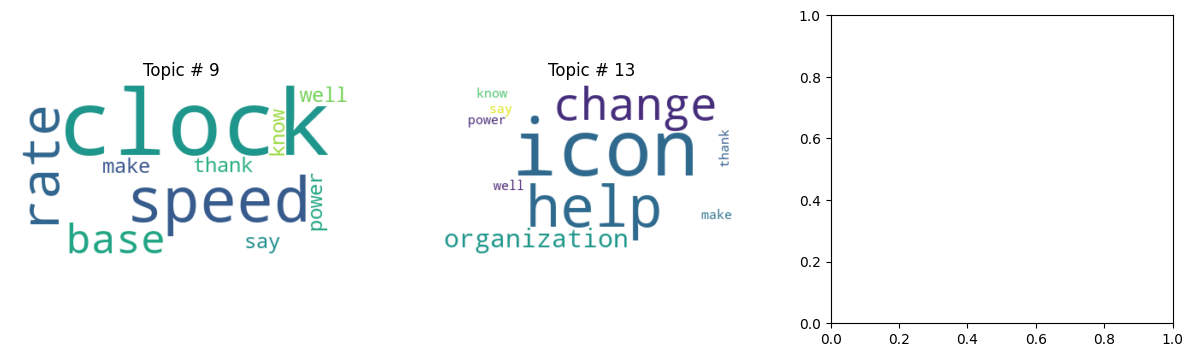

In [34]:
hdp_topics_to_wordclouds(hdp, hdp_topics)

### Cautionary Tale 3

In [35]:
from gensim.models import HdpModel

# Filter outlier words (e.g. appear <10 docs or in over 50% of docs)
vocab = corpora.Dictionary(word_list_lemmatized)
vocab.filter_extremes(no_below=20, no_above=0.5)
vocab.compactify()

# Build corpus
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Just changing the learning rate and truncation level
hdp = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=1, random_state=20) # default kappa
hdp08 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.8, random_state=20)
hdp06 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.6, random_state=20)

In [36]:
vb_model = [hdp06, hdp08, hdp]
vb_coherence =[]

for m in vb_model:
    cm = CoherenceModel(m, texts=word_list_lemmatized, corpus=corpus, dictionary=vocab, coherence='c_v')
    vb_coherence.append(cm.get_coherence())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
pd.DataFrame(vb_coherence, index=['hdp_kap06', 'hdp_kap08', 'hdp_kap1']).T


hdp_kap06  hdp_kap08  hdp_kap1
0        NaN        NaN       NaN

In [38]:
import pyLDAvis.gensim
py_corpus = [x for x in corpus if len(x) > 0]
prep= pyLDAvis.gensim.prepare(hdp, py_corpus, vocab)
pyLDAvis.display(prep)


ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.